In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart.csv


In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')

# Display basic information and the first few rows to understand the data structure
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0    

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Check for any missing values
print(df.isnull().sum())


2024-05-16 08:05:26.464169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 08:05:26.464270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 08:05:26.741601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load and preprocess data
data = pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')
X = data.drop('target', axis=1)
y = data['target']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the model building function
def build_improved_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the source and booster models
source_model = build_improved_model(X_train_pca.shape[1])
booster_model = build_improved_model(X_train_pca.shape[1])

# Setup callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# Train the source model
source_model.fit(X_train_pca, y_train, epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks, verbose=1)

# Get predictions and calculate pseudo labels for the booster model
pseudo_labels = source_model.predict(X_train_pca)

# Train the booster model with pseudo labels
booster_model.fit(X_train_pca, pseudo_labels, epochs=50, batch_size=128, validation_split=0.2, callbacks=callbacks, verbose=1)

# Evaluate the booster model
booster_performance = booster_model.evaluate(X_test_pca, y_test)
print("Booster Model Performance: ", booster_performance)

# Get predictions from the booster model
y_pred_proba = booster_model.predict(X_test_pca)

# Calculate Average Precision (AP) score
ap_score = average_precision_score(y_test, y_pred_proba)

# Calculate Area Under the ROC Curve (AUC-ROC) score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Average Precision (AP) Score: {ap_score:.4f}")
print(f"Area Under the ROC Curve (AUC) Score: {auc_score:.4f}")


Epoch 1/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.5391 - loss: 2.0495

I0000 00:00:1715853594.716905     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715853594.733769     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.5645 - loss: 1.9425

W0000 00:00:1715853599.028711     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.68223, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 941ms/step - accuracy: 0.5693 - loss: 1.9319 - val_accuracy: 0.6098 - val_loss: 1.6822
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6719 - loss: 1.7220
Epoch 2: val_loss improved from 1.68223 to 1.60155, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7449 - loss: 1.5712 - val_accuracy: 0.7500 - val_loss: 1.6016
Epoch 3/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8203 - loss: 1.4135
Epoch 3: val_loss improved from 1.60155 to 1.54745, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8176 - loss: 1.4442 - val_accuracy: 0.7866 - val_loss: 1.5474
Epoch 4/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8438 - loss: 1.3728
Epoch 4: val_loss improved from 1.54745 to 1.50434, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8476 - loss: 1.360

W0000 00:00:1715853609.791230     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.0000e+00 - loss: 1.8855

W0000 00:00:1715853613.794086     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss did not improve from 0.70415
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 857ms/step - accuracy: 0.0000e+00 - loss: 1.8792 - val_accuracy: 0.0000e+00 - val_loss: 1.7130
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 1.6550
Epoch 2: val_loss did not improve from 0.70415
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 1.6095 - val_accuracy: 0.0000e+00 - val_loss: 1.6360
Epoch 3/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 1.6044
Epoch 3: val_loss did not improve from 0.70415
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 1.5619 - val_accuracy: 0.0000e+00 - val_loss: 1.5756
Epoch 4/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 1.4833
Epoch 4: val_loss did not improve from 0.70415
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 1.4869 - val_accuracy: 0.0000e+00 - val_loss: 1.5266
Epoch 5/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score


In [7]:
# Calculate the binary classifications based on a default threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# ROC Curve and AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve and AUC
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# F1 Score
f1 = f1_score(y_test, y_pred)


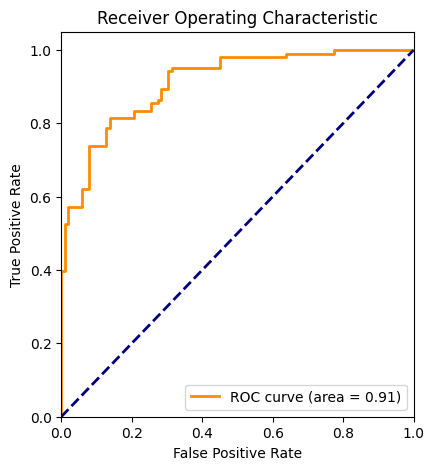

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


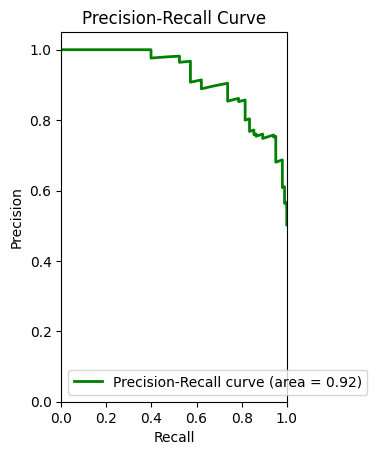

In [9]:
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [10]:
print("True Positives:", tp)
print("False Positives:", fp)
print("True Negatives:", tn)
print("False Negatives:", fn)
print("F1 Score: {:.4f}".format(f1))


True Positives: 83
False Positives: 14
True Negatives: 88
False Negatives: 20
F1 Score: 0.8300


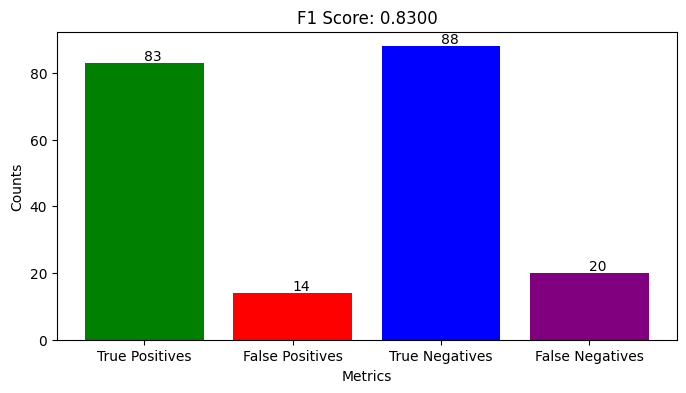

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# Assuming y_test and y_pred_proba are already defined
# Converting probabilities to binary predictions based on a default 0.5 threshold
y_pred = (np.array(y_pred_proba) > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Data for plotting
categories = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
values = [tp, fp, tn, fn]

# Create bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(categories, values, color=['green', 'red', 'blue', 'purple'])

# Add text annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Highlight the F1 Score in the plot
plt.title(f"F1 Score: {f1:.4f}")
plt.xlabel('Metrics')
plt.ylabel('Counts')
plt.show()